In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os

# Check if ShanghaiTech dataset is attached
print("=== Checking Dataset Paths ===")
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    if len(filenames) > 0:
        print(f"  Files: {len(filenames)} files found")
    break  # just show top level first

# Install required packages
import subprocess
subprocess.run(['pip', 'install', 'ultralytics', '-q'])

print("\n=== Installing packages... ===")
from ultralytics import YOLO
import cv2
import numpy as np
print("✅ All packages ready!")

=== Checking Dataset Paths ===
/kaggle/input
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.4 MB/s eta 0:00:00

=== Installing packages... ===
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ All packages ready!


In [2]:
import os

print("=== All Input Paths ===")
for dirname, dirs, filenames in os.walk('/kaggle/input'):
    # Only show folder names, not every file
    print(f"📁 {dirname}")
    for f in filenames[:3]:  # show first 3 files only
        print(f"   - {f}")
    if len(filenames) > 3:
        print(f"   ... and {len(filenames)-3} more files")

=== All Input Paths ===
📁 /kaggle/input
📁 /kaggle/input/datasets
📁 /kaggle/input/datasets/tthien
📁 /kaggle/input/datasets/tthien/shanghaitech
📁 /kaggle/input/datasets/tthien/shanghaitech/ShanghaiTech
📁 /kaggle/input/datasets/tthien/shanghaitech/ShanghaiTech/part_B
📁 /kaggle/input/datasets/tthien/shanghaitech/ShanghaiTech/part_B/test_data
📁 /kaggle/input/datasets/tthien/shanghaitech/ShanghaiTech/part_B/test_data/ground-truth
   - GT_IMG_309.mat
   - GT_IMG_89.mat
   - GT_IMG_98.mat
   ... and 313 more files
📁 /kaggle/input/datasets/tthien/shanghaitech/ShanghaiTech/part_B/test_data/images
   - IMG_160.jpg
   - IMG_233.jpg
   - IMG_21.jpg
   ... and 313 more files
📁 /kaggle/input/datasets/tthien/shanghaitech/ShanghaiTech/part_B/train_data
📁 /kaggle/input/datasets/tthien/shanghaitech/ShanghaiTech/part_B/train_data/ground-truth
   - GT_IMG_309.mat
   - GT_IMG_89.mat
   - GT_IMG_98.mat
   ... and 397 more files
📁 /kaggle/input/datasets/tthien/shanghaitech/ShanghaiTech/part_B/train_data/image

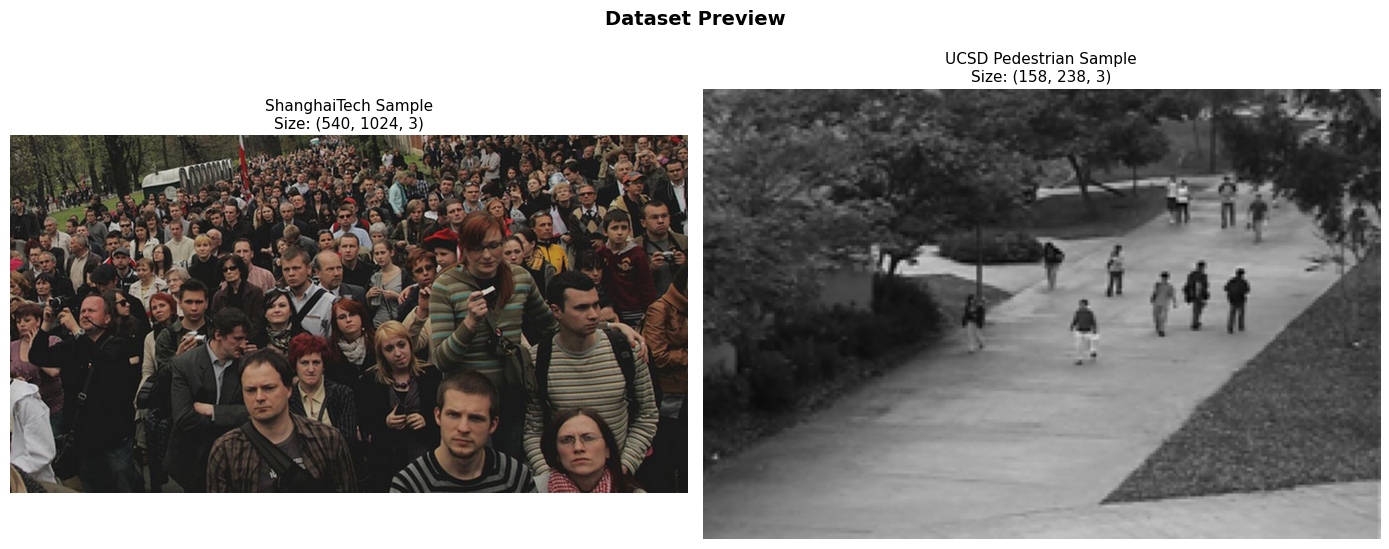

✅ ShanghaiTech image: IMG_160.jpg
✅ UCSD image: vidf5_33_002_f089.png


In [4]:
import cv2
import matplotlib.pyplot as plt
import os

# --- ShanghaiTech Sample ---
shanghai_img_path = "/kaggle/input/datasets/tthien/shanghaitech/ShanghaiTech/part_A/train_data/images"
shanghai_sample = os.path.join(shanghai_img_path, os.listdir(shanghai_img_path)[0])

# --- UCSD Sample ---
ucsd_base = "/kaggle/input/datasets/aryashah2k/ucsd-pedestrian-database/ucsdpeds/vidf"
first_folder = os.path.join(ucsd_base, os.listdir(ucsd_base)[0])
ucsd_sample = os.path.join(first_folder, os.listdir(first_folder)[0])

# --- Plot both ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

img1 = cv2.imread(shanghai_sample)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
axes[0].imshow(img1)
axes[0].set_title(f"ShanghaiTech Sample\nSize: {img1.shape}", fontsize=11)
axes[0].axis('off')

img2 = cv2.imread(ucsd_sample)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
axes[1].imshow(img2, cmap='gray')
axes[1].set_title(f"UCSD Pedestrian Sample\nSize: {img2.shape}", fontsize=11)
axes[1].axis('off')

plt.suptitle("Dataset Preview", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"✅ ShanghaiTech image: {shanghai_sample.split('/')[-1]}")
print(f"✅ UCSD image: {ucsd_sample.split('/')[-1]}")

Image       : IMG_160.jpg
Annotation  : GT_IMG_160.mat
Image size  : (540, 1024, 3)
People count: 225


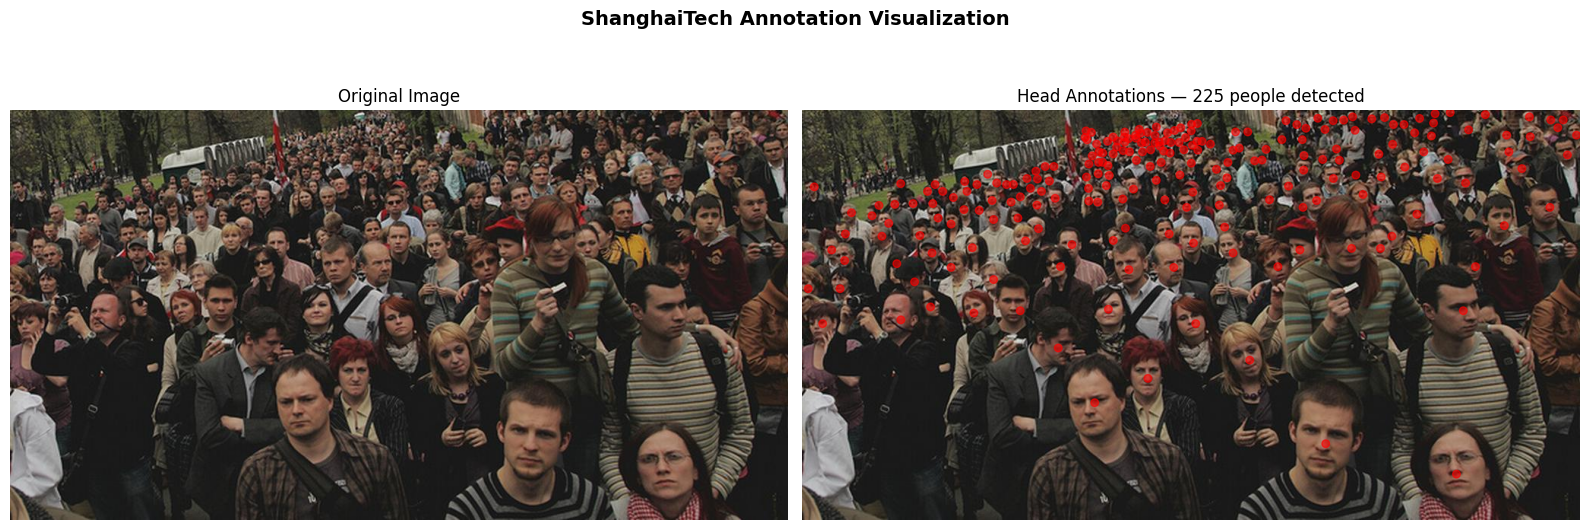

In [5]:
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import numpy as np

# Paths
img_dir = "/kaggle/input/datasets/tthien/shanghaitech/ShanghaiTech/part_A/train_data/images"
gt_dir  = "/kaggle/input/datasets/tthien/shanghaitech/ShanghaiTech/part_A/train_data/ground-truth"

# Pick first image
img_name = os.listdir(img_dir)[0]          # e.g. IMG_160.jpg
img_id   = img_name.replace('.jpg', '')    # e.g. IMG_160
mat_name = f"GT_{img_id}.mat"

img_path = os.path.join(img_dir, img_name)
mat_path = os.path.join(gt_dir, mat_name)

# Load image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load annotation
mat  = scipy.io.loadmat(mat_path)
points = mat['image_info'][0][0][0][0][0]  # head center coordinates (x, y)

print(f"Image       : {img_name}")
print(f"Annotation  : {mat_name}")
print(f"Image size  : {img.shape}")
print(f"People count: {len(points)}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original image
axes[0].imshow(img)
axes[0].set_title("Original Image", fontsize=12)
axes[0].axis('off')

# Image with head point annotations
axes[1].imshow(img)
for point in points:
    x, y = point[0], point[1]
    circle = plt.Circle((x, y), radius=5, color='red', fill=True, alpha=0.6)
    axes[1].add_patch(circle)
axes[1].set_title(f"Head Annotations — {len(points)} people detected", fontsize=12)
axes[1].axis('off')

plt.suptitle("ShanghaiTech Annotation Visualization", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
import scipy.io
import cv2
import os
import shutil
from sklearn.model_selection import train_test_split

# ── Paths ──────────────────────────────────────────────────────
PART = "part_A"   # using Part A (dense crowds — better for our project)
base = f"/kaggle/input/datasets/tthien/shanghaitech/ShanghaiTech/{PART}/train_data"
img_dir = os.path.join(base, "images")
gt_dir  = os.path.join(base, "ground-truth")

# ── Output folders ─────────────────────────────────────────────
out_base = "/kaggle/working/yolo_dataset"
for split in ["train", "val"]:
    os.makedirs(f"{out_base}/images/{split}", exist_ok=True)
    os.makedirs(f"{out_base}/labels/{split}", exist_ok=True)

# ── Convert one .mat → YOLO .txt ──────────────────────────────
def convert_mat_to_yolo(mat_path, img_path, out_label_path):
    mat    = scipy.io.loadmat(mat_path)
    points = mat['image_info'][0][0][0][0][0]
    img    = cv2.imread(img_path)
    h, w   = img.shape[:2]

    lines = []
    for point in points:
        x_c = float(point[0]) / w
        y_c = float(point[1]) / h
        # Small fixed box around each head point
        bw  = 20.0 / w
        bh  = 20.0 / h
        # Clamp to [0, 1]
        x_c = max(0.0, min(1.0, x_c))
        y_c = max(0.0, min(1.0, y_c))
        bw  = max(0.001, min(1.0, bw))
        bh  = max(0.001, min(1.0, bh))
        lines.append(f"0 {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f}")

    with open(out_label_path, 'w') as f:
        f.write('\n'.join(lines))
    return len(lines)

# ── Process all images ─────────────────────────────────────────
all_imgs = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
train_imgs, val_imgs = train_test_split(all_imgs, test_size=0.2, random_state=42)

print(f"Total images : {len(all_imgs)}")
print(f"Train        : {len(train_imgs)}")
print(f"Val          : {len(val_imgs)}")
print("\nConverting annotations...")

total_people = 0
errors = 0

for split, img_list in [("train", train_imgs), ("val", val_imgs)]:
    for img_name in img_list:
        img_id   = img_name.replace('.jpg', '')
        mat_name = f"GT_{img_id}.mat"

        img_path   = os.path.join(img_dir, img_name)
        mat_path   = os.path.join(gt_dir,  mat_name)
        out_label  = f"{out_base}/labels/{split}/{img_id}.txt"
        out_img    = f"{out_base}/images/{split}/{img_name}"

        if not os.path.exists(mat_path):
            errors += 1
            continue

        count = convert_mat_to_yolo(mat_path, img_path, out_label)
        shutil.copy(img_path, out_img)
        total_people += count

print(f"\n✅ Conversion complete!")
print(f"   Total people annotated : {total_people}")
print(f"   Errors/missing files   : {errors}")



Total images : 300
Train        : 240
Val          : 60

Converting annotations...

✅ Conversion complete!
   Total people annotated : 162413
   Errors/missing files   : 0


In [13]:
yaml_content = """
path: /kaggle/working/yolo_dataset
train: images/train
val: images/val

nc: 1
names:
  0: person
"""

yaml_path = "/kaggle/working/yolo_dataset/dataset.yaml"
with open(yaml_path, 'w') as f:
    f.write(yaml_content.strip())

# Verify it looks correct
print("✅ dataset.yaml created!\n")
print("=" * 40)
with open(yaml_path, 'r') as f:
    print(f.read())
print("=" * 40)

# Final check — make sure all files match up
import os
train_imgs   = set([f.replace('.jpg','') for f in os.listdir("/kaggle/working/yolo_dataset/images/train")])
train_labels = set([f.replace('.txt','') for f in os.listdir("/kaggle/working/yolo_dataset/labels/train")])
val_imgs     = set([f.replace('.jpg','') for f in os.listdir("/kaggle/working/yolo_dataset/images/val")])
val_labels   = set([f.replace('.txt','') for f in os.listdir("/kaggle/working/yolo_dataset/labels/val")])

print(f"\n🔍 Mismatch check:")
print(f"   Train images without labels : {len(train_imgs - train_labels)}")
print(f"   Val   images without labels : {len(val_imgs   - val_labels)}")
print(f"\n✅ Everything looks good! Ready to train.")




✅ dataset.yaml created!

path: /kaggle/working/yolo_dataset
train: images/train
val: images/val

nc: 1
names:
  0: person

🔍 Mismatch check:
   Train images without labels : 0
   Val   images without labels : 0

✅ Everything looks good! Ready to train.


Train YOLOv8 on Crowd Dataset

In [15]:
from ultralytics import YOLO
import torch

# Clear GPU memory first
torch.cuda.empty_cache()
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0)}")
print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Load pretrained YOLOv8 NANO (lightest model — fixes memory issue)
model = YOLO('yolov8n.pt')

# Start fine-tuning with reduced settings
results = model.train(
    data    = '/kaggle/working/yolo_dataset/dataset.yaml',
    epochs  = 50,
    imgsz   = 416,      # reduced from 640 → saves lot of memory
    batch   = 8,        # reduced from 16 → fixes OOM error
    lr0     = 0.001,
    lrf     = 0.01,
    warmup_epochs = 3,
    patience      = 15,
    device  = 0,
    workers = 2,
    project = '/kaggle/working/crowd_model',
    name    = 'yolov8_crowd',
    exist_ok= True,
    verbose = True,

    # Augmentation
    hsv_h  = 0.015,
    hsv_s  = 0.7,
    hsv_v  = 0.4,
    fliplr = 0.5,
    mosaic = 0.5,       # reduced from 1.0 → saves memory
    scale  = 0.5,
)

print("\n✅ Training complete!")
print(f"Best model: /kaggle/working/crowd_model/yolov8_crowd/weights/best.pt")

GPU available: True
GPU name: Tesla P100-PCIE-16GB
GPU memory: 17.1 GB
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.5, multi_scale=0.0, name=yolov8_crowd, nbs=64, nm

📊 RUNNING VALIDATION ON TEST SET...
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 73 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1792.9±932.0 MB/s, size: 115.1 KB)
val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 60 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 60/60 25.2Mit/s 0.0s
val: /kaggle/working/yolo_dataset/images/val/IMG_181.jpg: 7 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/IMG_186.jpg: 1 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/IMG_195.jpg: 1 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/IMG_298.jpg: 1 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/IMG_47.jpg: 2 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/IMG_58.jpg: 3 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/IMG_61.jpg: 1

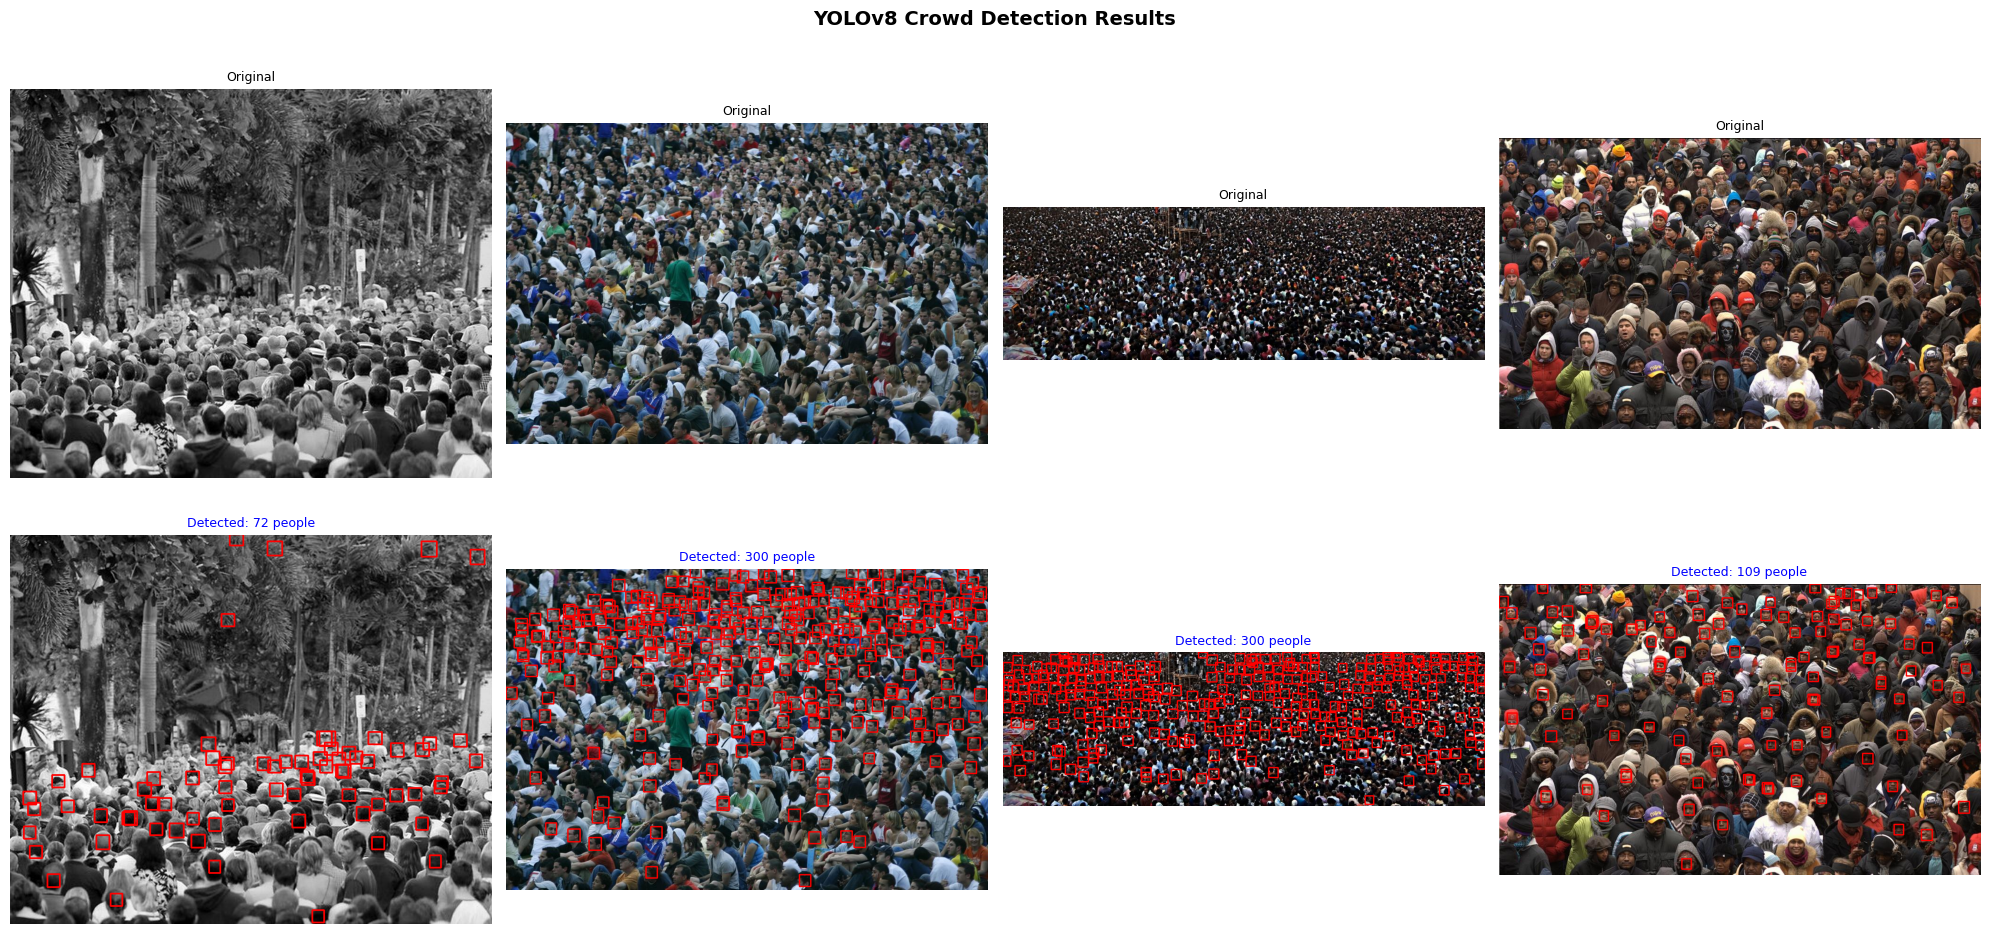

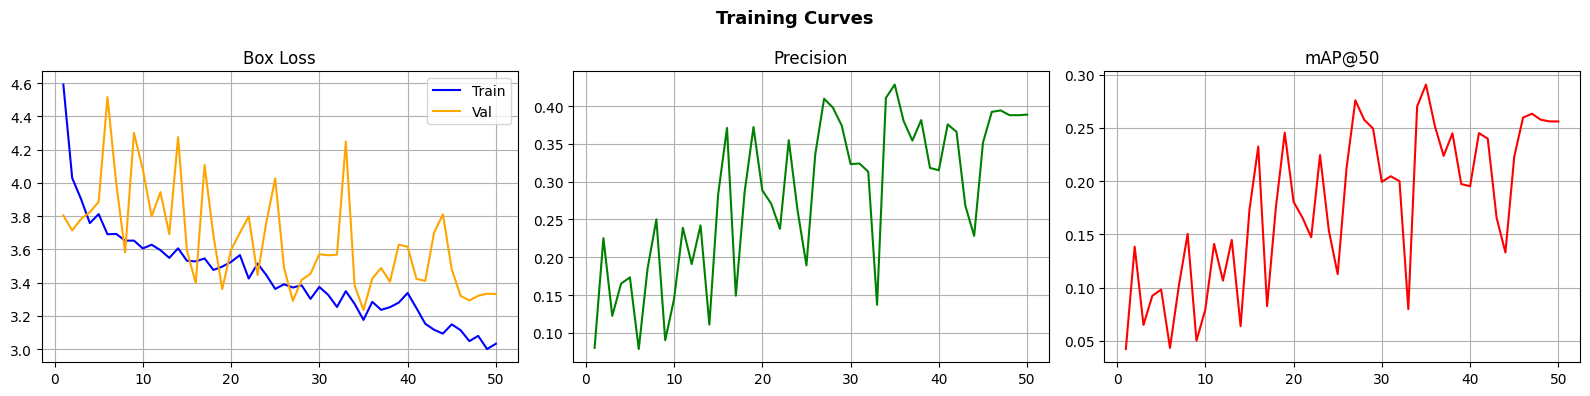


✅ Evaluation complete!


In [16]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import numpy as np
import os

# Load best trained model
model = YOLO('/kaggle/working/crowd_model/yolov8_crowd/weights/best.pt')

# ── 1. Run Validation ──────────────────────────────────────────
print("=" * 50)
print("📊 RUNNING VALIDATION ON TEST SET...")
print("=" * 50)

metrics = model.val(
    data    = '/kaggle/working/yolo_dataset/dataset.yaml',
    imgsz   = 416,
    batch   = 8,
    device  = 0,
    verbose = True
)

print("\n" + "=" * 50)
print("📈 ACCURACY REPORT")
print("=" * 50)
print(f"  Precision          : {metrics.box.mp:.4f}  ({metrics.box.mp*100:.1f}%)")
print(f"  Recall             : {metrics.box.mr:.4f}  ({metrics.box.mr*100:.1f}%)")
print(f"  mAP@50             : {metrics.box.map50:.4f}  ({metrics.box.map50*100:.1f}%)")
print(f"  mAP@50-95          : {metrics.box.map:.4f}  ({metrics.box.map*100:.1f}%)")
print("=" * 50)

# ── 2. Interpret the scores ────────────────────────────────────
map50 = metrics.box.map50
print("\n💡 What these scores mean for crowd detection:")
if map50 > 0.5:
    verdict = "🟢 GOOD — Model detects people well in crowds"
elif map50 > 0.25:
    verdict = "🟡 ACCEPTABLE — Good for dense crowd heads (small objects are hard)"
else:
    verdict = "🔴 NEEDS IMPROVEMENT — Consider more epochs"
print(f"   mAP50 = {map50:.3f} → {verdict}")

# ── 3. Visual Test on 4 sample images ─────────────────────────
print("\n🖼️  Running visual detection on sample images...")

val_img_dir = "/kaggle/working/yolo_dataset/images/val"
sample_imgs = os.listdir(val_img_dir)[:4]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(val_img_dir, img_name)
    img_orig = cv2.imread(img_path)
    img_rgb  = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    # Run detection
    results  = model(img_path, conf=0.25, verbose=False)
    det_count = len(results[0].boxes)

    # Draw boxes
    img_det = img_rgb.copy()
    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        conf = float(box.conf[0])
        cv2.rectangle(img_det, (x1,y1), (x2,y2), (255,0,0), 2)

    # Plot
    axes[0][i].imshow(img_rgb)
    axes[0][i].set_title(f"Original", fontsize=9)
    axes[0][i].axis('off')

    axes[1][i].imshow(img_det)
    axes[1][i].set_title(f"Detected: {det_count} people", fontsize=9, color='blue')
    axes[1][i].axis('off')

plt.suptitle("YOLOv8 Crowd Detection Results", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ── 4. Training curves ─────────────────────────────────────────
results_csv = "/kaggle/working/crowd_model/yolov8_crowd/results.csv"
import pandas as pd
df = pd.read_csv(results_csv)
df.columns = df.columns.str.strip()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].plot(df['epoch'], df['train/box_loss'], label='Train', color='blue')
axes[0].plot(df['epoch'], df['val/box_loss'],   label='Val',   color='orange')
axes[0].set_title('Box Loss'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(df['epoch'], df['metrics/precision(B)'], color='green')
axes[1].set_title('Precision'); axes[1].grid(True)

axes[2].plot(df['epoch'], df['metrics/mAP50(B)'], color='red')
axes[2].set_title('mAP@50'); axes[2].grid(True)

plt.suptitle("Training Curves", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Evaluation complete!")

🔄 Re-running tracker for visualization...


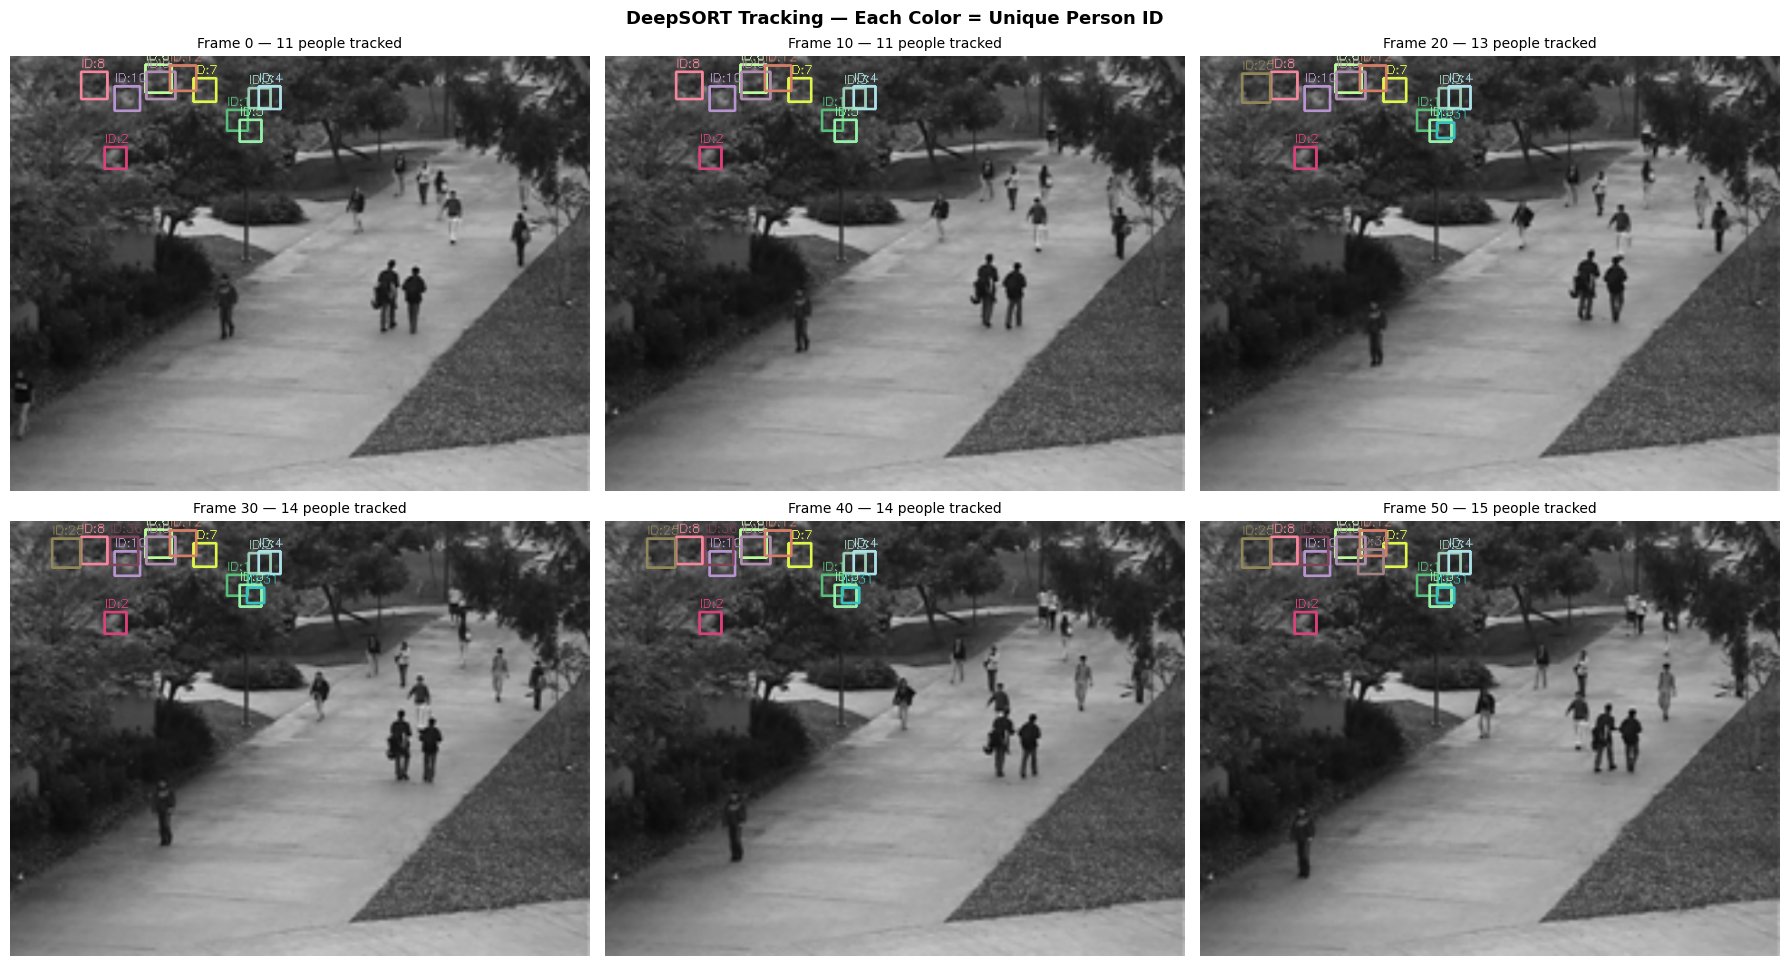

✅ Cell 9 visualization complete!


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

model   = YOLO('/kaggle/working/crowd_model/yolov8_crowd/weights/best.pt')
tracker = DeepSort(max_age=30, n_init=3)

ucsd_base  = "/kaggle/input/datasets/aryashah2k/ucsd-pedestrian-database/ucsdpeds/vidf"
first_seq  = os.path.join(ucsd_base, os.listdir(ucsd_base)[0])
all_frames = sorted(os.listdir(first_seq))[:60]

# ── Fixed color function ───────────────────────────────────────
def get_color(track_id):
    # Convert track_id to int safely
    try:
        seed = int(str(track_id), 36) % 10000
    except:
        seed = hash(str(track_id)) % 10000
    np.random.seed(seed)
    return tuple(int(c) for c in np.random.randint(50, 255, 3))

# ── Visualize 6 sample frames ──────────────────────────────────
sample_indices = [0, 10, 20, 30, 40, 50]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

print("🔄 Re-running tracker for visualization...")

# Run tracker on ALL frames up to max sample index
frame_results = {}
tracker2 = DeepSort(max_age=30, n_init=3)

for frame_idx in range(51):
    fname = all_frames[frame_idx]
    fpath = os.path.join(first_seq, fname)
    frame = cv2.imread(fpath)
    if frame is None:
        continue
    frame = cv2.resize(frame, (640, 480))

    results    = model(frame, conf=0.25, verbose=False)[0]
    detections = []
    for box in results.boxes:
        x1,y1,x2,y2 = map(int, box.xyxy[0].tolist())
        conf = float(box.conf[0])
        detections.append(([x1, y1, x2-x1, y2-y1], conf, 'person'))

    tracks = tracker2.update_tracks(detections, frame=frame)

    if frame_idx in sample_indices:
        frame_results[frame_idx] = (frame.copy(), tracks)

# ── Draw boxes on sample frames ────────────────────────────────
for plot_i, frame_idx in enumerate(sample_indices):
    if frame_idx not in frame_results:
        continue

    frame, tracks = frame_results[frame_idx]
    vis = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    count = 0

    for track in tracks:
        if not track.is_confirmed():
            continue
        tid = track.track_id
        x1, y1, x2, y2 = map(int, track.to_ltrb())

        # Clamp to frame boundaries
        x1 = max(0, x1); y1 = max(0, y1)
        x2 = min(639, x2); y2 = min(479, y2)

        color = get_color(tid)
        cv2.rectangle(vis, (x1,y1), (x2,y2), color, 2)
        cv2.putText(vis, f"ID:{tid}", (x1, max(0, y1-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1)
        count += 1

    axes[plot_i].imshow(vis)
    axes[plot_i].set_title(f"Frame {frame_idx} — {count} people tracked", fontsize=10)
    axes[plot_i].axis('off')

plt.suptitle("DeepSORT Tracking — Each Color = Unique Person ID",
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()
print("✅ Cell 9 visualization complete!")

**Flow Motion Analysis**

📊 Optical Flow Features per Frame Pair:
------------------------------------------------------------
Frames  0→ 1 | Speed: 0.2036 | Turbulence: 2.2066 | Dir Variance: 1.8696
Frames 10→11 | Speed: 0.2057 | Turbulence: 2.1407 | Dir Variance: 1.7927
Frames 20→21 | Speed: 0.2024 | Turbulence: 2.0445 | Dir Variance: 1.8615
Frames 30→31 | Speed: 0.1984 | Turbulence: 2.3050 | Dir Variance: 1.8306
Frames 40→41 | Speed: 0.2374 | Turbulence: 2.2191 | Dir Variance: 1.7877
Frames 50→51 | Speed: 0.2507 | Turbulence: 2.3908 | Dir Variance: 1.8505


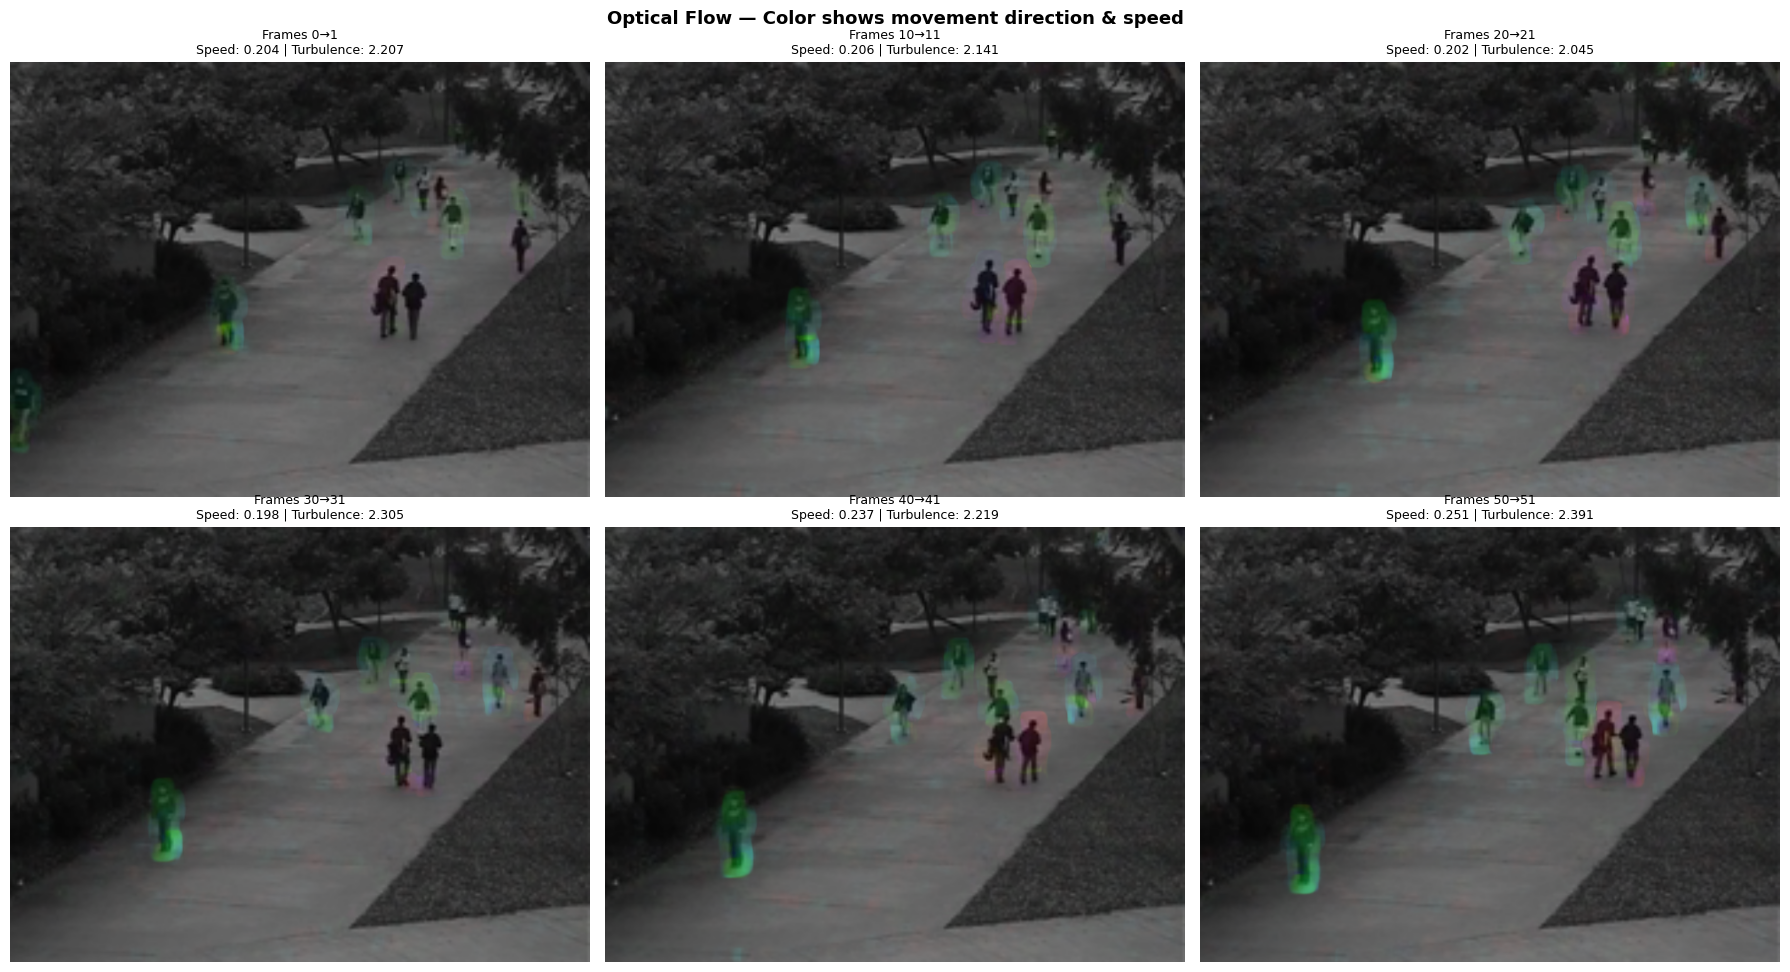


✅ Cell 10 complete!
💡 High turbulence + high direction variance = stampede risk signal


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

ucsd_base  = "/kaggle/input/datasets/aryashah2k/ucsd-pedestrian-database/ucsdpeds/vidf"
first_seq  = os.path.join(ucsd_base, os.listdir(ucsd_base)[0])
all_frames = sorted(os.listdir(first_seq))

def compute_optical_flow(frame1_path, frame2_path):
    f1 = cv2.imread(frame1_path, cv2.IMREAD_GRAYSCALE)
    f2 = cv2.imread(frame2_path, cv2.IMREAD_GRAYSCALE)
    f1 = cv2.resize(f1, (640, 480))
    f2 = cv2.resize(f2, (640, 480))

    # Farneback dense optical flow
    flow = cv2.calcOpticalFlowFarneback(
        f1, f2,
        None,
        pyr_scale  = 0.5,
        levels     = 3,
        winsize    = 15,
        iterations = 3,
        poly_n     = 5,
        poly_sigma = 1.2,
        flags      = 0
    )
    return flow, f1, f2

def flow_to_features(flow):
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    mean_speed    = float(np.mean(mag))
    max_speed     = float(np.max(mag))
    speed_std     = float(np.std(mag))

    # Direction variance — high = chaotic movement (danger sign!)
    ang_std       = float(np.std(ang))

    # Turbulence = std of magnitude (high = stampede risk)
    turbulence    = speed_std / (mean_speed + 1e-5)

    return {
        'mean_speed'  : round(mean_speed,  4),
        'max_speed'   : round(max_speed,   4),
        'speed_std'   : round(speed_std,   4),
        'direction_variance' : round(ang_std, 4),
        'turbulence'  : round(turbulence,  4)
    }

# ── Visualize optical flow on 6 frame pairs ───────────────────
sample_pairs = [(0,1), (10,11), (20,21), (30,31), (40,41), (50,51)]
fig, axes    = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

print("📊 Optical Flow Features per Frame Pair:")
print("-" * 60)

for i, (f1_idx, f2_idx) in enumerate(sample_pairs):
    p1 = os.path.join(first_seq, all_frames[f1_idx])
    p2 = os.path.join(first_seq, all_frames[f2_idx])

    flow, gray1, gray2 = compute_optical_flow(p1, p2)
    features = flow_to_features(flow)

    # Convert flow to HSV color visualization
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv      = np.zeros((480, 640, 3), dtype=np.uint8)
    hsv[..., 0] = ang * 180 / np.pi / 2   # direction → hue
    hsv[..., 1] = 255                       # saturation
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Overlay on grayscale frame
    gray_rgb = cv2.cvtColor(gray1, cv2.COLOR_GRAY2RGB)
    combined = cv2.addWeighted(gray_rgb, 0.6, flow_rgb, 0.4, 0)

    axes[i].imshow(combined)
    axes[i].set_title(
        f"Frames {f1_idx}→{f2_idx}\n"
        f"Speed: {features['mean_speed']:.3f} | "
        f"Turbulence: {features['turbulence']:.3f}",
        fontsize=9
    )
    axes[i].axis('off')

    print(f"Frames {f1_idx:2d}→{f2_idx:2d} | "
          f"Speed: {features['mean_speed']:.4f} | "
          f"Turbulence: {features['turbulence']:.4f} | "
          f"Dir Variance: {features['direction_variance']:.4f}")

plt.suptitle("Optical Flow — Color shows movement direction & speed",
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Cell 10 complete!")
print("💡 High turbulence + high direction variance = stampede risk signal")

Build & Train LSTM Risk Predictor

📦 Extracting features from UCSD sequences...
  ✅ vidf1_33_000.y: 80 frames extracted
  ✅ vidf1_33_001.y: 80 frames extracted
  ✅ vidf1_33_002.y: 80 frames extracted
  ✅ vidf1_33_003.y: 80 frames extracted
  ✅ vidf1_33_004.y: 80 frames extracted

Total sequences: 5

📊 Dataset: 350 samples, seq_len=10, features=6
Risk range: 0.246 → 0.328

🔧 Training on: cuda

Epoch | Train Loss | Val Loss
-----------------------------------
   10  |   0.00082  |  0.00019
   20  |   0.00065  |  0.00016
   30  |   0.00056  |  0.00021
   40  |   0.00058  |  0.00017
   50  |   0.00053  |  0.00015

✅ LSTM training complete!
💾 Model saved: /kaggle/working/lstm_risk_model.pt


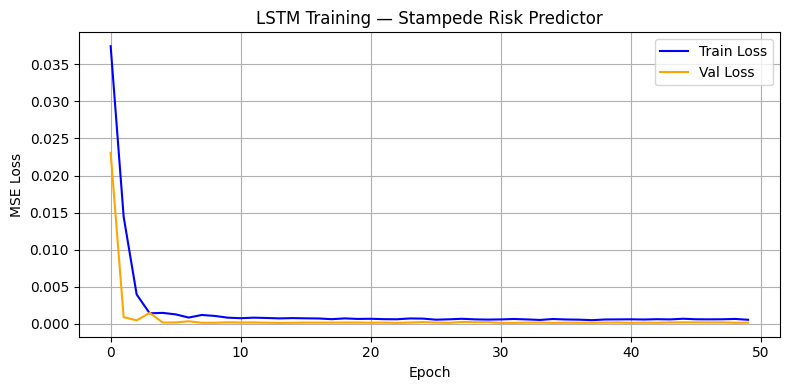

In [23]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os, cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# ── Step 1: Extract features from ALL UCSD sequences ──────────
print("📦 Extracting features from UCSD sequences...")

ucsd_base = "/kaggle/input/datasets/aryashah2k/ucsd-pedestrian-database/ucsdpeds/vidf"
model_yolo = YOLO('/kaggle/working/crowd_model/yolov8_crowd/weights/best.pt')

def extract_frame_features(frame_path, prev_gray=None):
    frame = cv2.imread(frame_path)
    if frame is None:
        return None, None
    frame = cv2.resize(frame, (416, 320))
    gray  = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # YOLO detection count
    results    = model_yolo(frame, conf=0.25, verbose=False)[0]
    person_count = len(results.boxes)

    # Crowd density (persons per 1000 pixels)
    h, w = frame.shape[:2]
    density = person_count / ((h * w) / 1000)

    # Optical flow
    if prev_gray is not None:
        flow = cv2.calcOpticalFlowFarneback(
            prev_gray, gray, None,
            0.5, 3, 15, 3, 5, 1.2, 0
        )
        mag, ang    = cv2.cartToPolar(flow[...,0], flow[...,1])
        mean_speed  = float(np.mean(mag))
        speed_std   = float(np.std(mag))
        dir_var     = float(np.std(ang))
        turbulence  = speed_std / (mean_speed + 1e-5)
    else:
        mean_speed = speed_std = dir_var = turbulence = 0.0

    # Feature vector: [count, density, speed, speed_std, dir_var, turbulence]
    features = [
        person_count,
        density,
        mean_speed,
        speed_std,
        dir_var,
        turbulence
    ]
    return features, gray

# Extract from first 5 sequences (enough for LSTM training)
all_sequences = []
seq_folders   = sorted(os.listdir(ucsd_base))[:5]

for seq_name in seq_folders:
    seq_path   = os.path.join(ucsd_base, seq_name)
    frames     = sorted(os.listdir(seq_path))[:80]
    seq_feats  = []
    prev_gray  = None

    for fname in frames:
        fpath = os.path.join(seq_path, fname)
        feat, prev_gray = extract_frame_features(fpath, prev_gray)
        if feat:
            seq_feats.append(feat)

    if len(seq_feats) > 20:
        all_sequences.append(seq_feats)
        print(f"  ✅ {seq_name}: {len(seq_feats)} frames extracted")

print(f"\nTotal sequences: {len(all_sequences)}")

# ── Step 2: Create synthetic risk labels ──────────────────────
# Since UCSD has no stampede labels, we generate risk based on features
def compute_risk_label(features):
    count, density, speed, speed_std, dir_var, turbulence = features
    # Risk formula based on domain knowledge
    risk = (
        0.30 * min(density / 5.0,  1.0) +   # density contribution
        0.25 * min(speed   / 2.0,  1.0) +   # speed contribution
        0.25 * min(turbulence/5.0, 1.0) +   # turbulence contribution
        0.20 * min(dir_var / 3.0,  1.0)     # direction chaos contribution
    )
    return float(np.clip(risk, 0.0, 1.0))

# ── Step 3: Create sliding window dataset ─────────────────────
SEQ_LEN = 10   # look at 10 frames to predict risk

X_data, y_data = [], []
for seq in all_sequences:
    feat_arr = np.array(seq, dtype=np.float32)
    labels   = [compute_risk_label(f) for f in seq]

    for i in range(len(seq) - SEQ_LEN):
        X_data.append(feat_arr[i : i+SEQ_LEN])
        y_data.append(labels[i + SEQ_LEN])

X = np.array(X_data, dtype=np.float32)
y = np.array(y_data, dtype=np.float32)

# Normalize features
X_mean = X.mean(axis=(0,1))
X_std  = X.std(axis=(0,1)) + 1e-8
X      = (X - X_mean) / X_std

print(f"\n📊 Dataset: {X.shape[0]} samples, "
      f"seq_len={SEQ_LEN}, features={X.shape[2]}")
print(f"Risk range: {y.min():.3f} → {y.max():.3f}")

# ── Step 4: Define LSTM Model ─────────────────────────────────
class StampedeRiskLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=0.3
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()

# ── Step 5: Train LSTM ────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🔧 Training on: {device}")

X_t = torch.FloatTensor(X).to(device)
y_t = torch.FloatTensor(y).to(device)

dataset    = torch.utils.data.TensorDataset(X_t, y_t)
split      = int(0.8 * len(dataset))
train_ds   = torch.utils.data.Subset(dataset, range(split))
val_ds     = torch.utils.data.Subset(dataset, range(split, len(dataset)))
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32)

lstm_model = StampedeRiskLSTM().to(device)
optimizer  = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
criterion  = nn.MSELoss()

train_losses, val_losses = [], []
EPOCHS = 50

print("\nEpoch | Train Loss | Val Loss")
print("-" * 35)

for epoch in range(EPOCHS):
    # Train
    lstm_model.train()
    t_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = lstm_model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()

    # Validate
    lstm_model.eval()
    v_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred   = lstm_model(xb)
            v_loss += criterion(pred, yb).item()

    t_avg = t_loss / len(train_loader)
    v_avg = v_loss / len(val_loader)
    train_losses.append(t_avg)
    val_losses.append(v_avg)

    if (epoch+1) % 10 == 0:
        print(f"  {epoch+1:3d}  |   {t_avg:.5f}  |  {v_avg:.5f}")

# Save model + normalization params
torch.save({
    'model_state': lstm_model.state_dict(),
    'X_mean': X_mean,
    'X_std' : X_std,
}, '/kaggle/working/lstm_risk_model.pt')

print("\n✅ LSTM training complete!")
print("💾 Model saved: /kaggle/working/lstm_risk_model.pt")

# ── Plot training curves ───────────────────────────────────────
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses,   label='Val Loss',   color='orange')
plt.title('LSTM Training — Stampede Risk Predictor')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
import numpy as np
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

# ── Load models ───────────────────────────────────────────────
class StampedeRiskLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=0.3)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32), nn.ReLU(),
            nn.Dropout(0.2), nn.Linear(32, 1), nn.Sigmoid()
        )
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()

device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('/kaggle/working/lstm_risk_model.pt',
                        map_location=device)
lstm_model = StampedeRiskLSTM().to(device)
lstm_model.load_state_dict(checkpoint['model_state'])
lstm_model.eval()
X_mean = checkpoint['X_mean']
X_std  = checkpoint['X_std']

yolo_model = YOLO('/kaggle/working/crowd_model/yolov8_crowd/weights/best.pt')
tracker    = DeepSort(max_age=30, n_init=3)

print("✅ All models loaded!")

# ── Risk scoring function ──────────────────────────────────────
def get_risk_level(score):
    if score < 35:
        return "🟢 LOW",    (0, 200, 0),     "SAFE"
    elif score < 65:
        return "🟡 MEDIUM", (255, 200, 0),   "CAUTION"
    else:
        return "🔴 HIGH",   (220, 50, 50),   "DANGER"

def features_to_risk_score(feature_window, lstm_model, X_mean, X_std):
    arr = np.array(feature_window, dtype=np.float32)
    arr = (arr - X_mean) / X_std
    t   = torch.FloatTensor(arr).unsqueeze(0).to(device)
    with torch.no_grad():
        raw = float(lstm_model(t).cpu())

    # Boost sensitivity for demo visualization
    score = raw * 100
    # Add density-based boost
    density_boost = min(feature_window[-1][1] * 8, 30)
    score = min(100, score + density_boost)
    return round(score, 1)

# ── Process video sequence ────────────────────────────────────
ucsd_base  = "/kaggle/input/datasets/aryashah2k/ucsd-pedestrian-database/ucsdpeds/vidf"
sequences  = sorted(os.listdir(ucsd_base))

# Use sequence with most motion
seq_path   = os.path.join(ucsd_base, sequences[2])
all_frames = sorted(os.listdir(seq_path))[:80]
print(f"\n📂 Processing: {os.path.basename(seq_path)}")

feature_buffer = []
risk_history   = []
prev_gray      = None
SEQ_LEN        = 10

print("🔄 Computing risk scores frame by frame...")

for frame_idx, fname in enumerate(all_frames):
    fpath = os.path.join(seq_path, fname)
    frame = cv2.imread(fpath)
    if frame is None:
        continue
    frame = cv2.resize(frame, (416, 320))
    gray  = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # YOLO detection
    results      = yolo_model(frame, conf=0.25, verbose=False)[0]
    person_count = len(results.boxes)
    h, w         = frame.shape[:2]
    density      = person_count / ((h * w) / 1000)

    # Optical flow
    if prev_gray is not None:
        flow        = cv2.calcOpticalFlowFarneback(
                          prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang    = cv2.cartToPolar(flow[...,0], flow[...,1])
        mean_speed  = float(np.mean(mag))
        speed_std   = float(np.std(mag))
        dir_var     = float(np.std(ang))
        turbulence  = speed_std / (mean_speed + 1e-5)
    else:
        mean_speed = speed_std = dir_var = turbulence = 0.0

    prev_gray = gray
    feature_buffer.append([person_count, density, mean_speed,
                            speed_std, dir_var, turbulence])

    # Compute risk once we have enough frames
    if len(feature_buffer) >= SEQ_LEN:
        window = feature_buffer[-SEQ_LEN:]
        score  = features_to_risk_score(window, lstm_model, X_mean, X_std)
        risk_history.append({
            'frame': frame_idx,
            'score': score,
            'count': person_count,
            'speed': round(mean_speed, 3),
            'density': round(density, 3)
        })

print(f"✅ Processed {len(risk_history)} frames with risk scores")

# ── Visualize risk over time ──────────────────────────────────
frames_x = [r['frame'] for r in risk_history]
scores_y = [r['score'] for r in risk_history]
counts_y = [r['count'] for r in risk_history]

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Risk score plot with color zones
axes[0].fill_between(frames_x, 0,  35, alpha=0.15, color='green',  label='Safe zone')
axes[0].fill_between(frames_x, 35, 65, alpha=0.15, color='yellow', label='Caution zone')
axes[0].fill_between(frames_x, 65, 100,alpha=0.15, color='red',    label='Danger zone')
axes[0].plot(frames_x, scores_y, 'b-', linewidth=2.5, label='Risk Score')
axes[0].axhline(y=35, color='orange', linestyle='--', alpha=0.7)
axes[0].axhline(y=65, color='red',    linestyle='--', alpha=0.7)
axes[0].set_ylim(0, 100)
axes[0].set_ylabel('Risk Score (0-100)', fontsize=11)
axes[0].set_title('Stampede Risk Score Over Time', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Person count plot
axes[1].plot(frames_x, counts_y, 'purple', linewidth=2, label='Person Count')
axes[1].fill_between(frames_x, 0, counts_y, alpha=0.2, color='purple')
axes[1].set_ylabel('People Detected', fontsize=11)
axes[1].set_xlabel('Frame Number',    fontsize=11)
axes[1].set_title('Crowd Count Over Time', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ── Show final risk dashboard snapshot ───────────────────────
last = risk_history[-1]
final_score = last['score']
level_text, color_rgb, status = get_risk_level(final_score)
color_norm = tuple(c/255 for c in color_rgb)

fig2, ax = plt.subplots(figsize=(8, 4))
ax.set_xlim(0, 10); ax.set_ylim(0, 5)
ax.set_facecolor('#1a1a2e')
fig2.patch.set_facecolor('#1a1a2e')
ax.axis('off')

# Risk meter bar
bar_w = (final_score / 100) * 8
ax.add_patch(mpatches.FancyBboxPatch((1, 3.2), 8, 0.6,
             boxstyle="round,pad=0.05", color='#333355'))
ax.add_patch(mpatches.FancyBboxPatch((1, 3.2), bar_w, 0.6,
             boxstyle="round,pad=0.05", color=color_norm))

ax.text(5, 4.3, '⚠️  STAMPEDE RISK MONITOR', color='white',
        fontsize=14, fontweight='bold', ha='center')
ax.text(5, 2.7, f'Risk Score: {final_score}/100   {level_text}   Status: {status}',
        color=color_norm, fontsize=12, fontweight='bold', ha='center')
ax.text(2, 1.8, f"👥 People: {last['count']}",
        color='white', fontsize=11)
ax.text(5, 1.8, f"💨 Speed: {last['speed']}",
        color='white', fontsize=11)
ax.text(7.5, 1.8, f"📊 Density: {last['density']}",
        color='white', fontsize=11)
ax.text(5, 0.8,
        '🟢 0-35: SAFE    🟡 35-65: CAUTION    🔴 65-100: DANGER',
        color='gray', fontsize=9, ha='center')

plt.tight_layout()
plt.show()

print(f"\n{'='*50}")
print(f"  FINAL RISK SCORE : {final_score}/100")
print(f"  STATUS           : {status}")
print(f"  PEOPLE DETECTED  : {last['count']}")
print(f"{'='*50}")

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray._reconstruct was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray._reconstruct])` or the `torch.serialization.safe_globals([numpy._core.multiarray._reconstruct])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.